In [2]:
import sys
sys.path.append("../script/")

from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
import Functions
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier

In [3]:
import numpy as np
import pandas as pd
from time import time

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# Estimator

In [5]:
class Estimator:
    def __init__(self,bins=None,lam=None):
        self.bins = bins
        self.lam = lam

    def set_bins_params(self,val):
        bins = self.bins
        val_max = np.max(val)
        val_min = np.min(val)
        width = ((val_max - val_min)/bins)

        self.val_min = val_min
        self.width = width

    def fit(self,val,residual,p):
        self.set_bins_params(val)
        index = self.get_index(val)

        residual_bin = np.stack([np.sum(residual[index==i],axis=0) for i in range(self.bins)])
        cover_bin = np.stack([np.sum(np.multiply(p[index==i],1-p[index==i]),axis=0) for i in range(self.bins)])
        cover_bin = cover_bin + self.lam #lambda

        grad_bin = np.divide(residual_bin,cover_bin,where=cover_bin!=0,out=np.zeros(cover_bin.shape))
        
        self.residual_bin = residual_bin
        self.cover_bin = cover_bin
        self.grad_bin = grad_bin
        
        grads = self.get_grads(index)

        return grads


    def get_index(self,val):
        index = ((val - self.val_min)//self.width).astype('int32') if self.width !=0 else np.zeros(val.shape[0])
        index = np.where(index >= self.bins,self.bins-1,index)
        index = np.where(index < 0,0,index)

        return index

    def get_grads(self,index):
        grads = np.zeros((index.shape[0],self.grad_bin.shape[1]))
        for i in range(self.bins):
            grads[index==i] = self.grad_bin[i]
        return grads


    def predict_grad(self,val):
        index = self.get_index(val)
        grads = self.get_grads(index)
        return grads

# Decision Tree Estimator

In [6]:
class Estimator_DC:
    def __init__(self,max_depth=None,lam=None):
        self.max_depth = max_depth
        self.lam = lam

    def set_grads_bin(self,residual,p):
        residual_bin = np.stack([np.sum(residual[self.index==i],axis=0) for i in range(self.bins)])
        cover_bin = np.stack([np.sum(np.multiply(p[self.index==i],1-p[self.index==i]),axis=0) for i in range(self.bins)])
        cover_bin = cover_bin + self.lam #lambda

        grad_bin = np.divide(residual_bin,cover_bin,where=cover_bin!=0,out=np.zeros(cover_bin.shape))

        self.residual_bin = residual_bin
        self.cover_bin = cover_bin
        self.grad_bin = grad_bin

        return self.get_grads(self.index)

    def fit(self,val,y):
        val = val.reshape(-1,1)

        self.clf = DecisionTreeClassifier(max_depth=self.max_depth)
        self.clf.fit(val,y)
        self.index = self.get_index(val)
        
        self.bins = len(self.clf.tree_.threshold)

    # def get_loss(self,base_gini):
    #     self.loss = -(base_gini - np.sum(self.clf.tree_.impurity))

    #     return self.loss

    def get_loss(self):
        self.loss = self.clf.tree_.impurity@(self.clf.tree_.n_node_samples/sum(self.clf.tree_.n_node_samples))
        return self.loss

    # def get_loss(self,grads,log_odds,p,learning_rate):
        # log_odds_1 = log_odds + learning_rate * grads
        
        # p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
        # p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
        
        # self.loss = np.sum(np.power(self.Y - p_1,2))
        # self.loss = -np.sum(np.power(self.p - p_1,2))
        # self.loss = -np.sum(np.abs(grads))
    #     return self.loss

    def get_index(self,val):
        val = val.reshape(-1,1)
        index = self.clf.apply(val)

        return index

    def get_grads(self,index):
        grads = np.zeros((index.shape[0],self.grad_bin.shape[1]))
        for i in range(self.bins):
            grads[index==i] = self.grad_bin[i]
        return grads


    def predict_grad(self,val):
        index = self.get_index(val)
        grads = self.get_grads(index)
        return grads

# Node

In [7]:
class Node:
    def __init__(self,terminal,func=None,sons=None,index=None,fit=None,estimator=None):
        self.terminal = terminal
        self.sons = sons
        self.func = func
        self.index = index
        self.fitness = fit
        self.estimator = estimator
        if self.terminal:
            self.depth = 0
            self.numNode = 1
        else:
            self.depth = max([s.depth for s in sons]) + 1
            self.numNode = sum([s.numNode for s in sons])+ 1

    def predict_grad(self,X):
        val = self.predict_val(X)
        return self.estimator.predict_grad(val)
        
    def predict_val(self,X):
        X = X.astype('float64')
        return self.pred_rec(X.T)
    def pred_rec(self,X):
        if not self.terminal:
            return self.func([s.pred_rec(X) for s in self.sons])
        else:
            return X[self.index]
    def __str__(self):
        if self.terminal:
            return "|"+str(self.index)+"|"
        else:
            string = "( " + str(self.func.__name__) + " -> "
            for s in self.sons:
                string += str(s) + " "
            string += ")"
            return string
    def __repr__(self):
        if self.terminal:
            return "|"+str(self.index)+"|"
        else:
            string = "( " + str(self.func.__name__) + " -> "
            for s in self.sons:
                string += str(s) + " "
            string += ")"
            return string

# Engine

In [8]:
class Engine:
    def __init__(self,opset,X,Y,Y_one_hot,log_odds,p,learning_rate,bins):
        self.generation = 0
        
        X = X.astype('float64')
        self.opset = opset
        
        self.feature_space = X.shape[1]
        
        self.vals = X.T
        self.X = X
        self.Y = Y
        self.Y_one_hot = Y_one_hot

        base_gini = (pd.value_counts(y_train)/y_train.shape)
        self.base_gini = sum(base_gini*(1-base_gini))

        self.log_odds = log_odds
        self.p = p
        self.residual = Y_one_hot - p
        self.learning_rate = learning_rate
        self.bins = bins
        
        self.best = (np.inf,None)
        self.nodes = [Node(True,index=i) for i in range(self.feature_space)]
    
    # def calculate_grad(self,val,lam):
    #     bins = self.bins
    #     val_max = np.max(val)
    #     val_min = np.min(val)
    #     width = ((val_max - val_min)/bins)

    #     index = ((val - val_min)//width).astype('int32') if width != 0 else np.zeros(val.shape[0])
    #     index = np.where(index >= bins,bins-1,index)
    #     index = np.where(index < 0,0,index)

    #     residual_bin = np.stack([np.sum(self.residual[index==i],axis=0) for i in range(bins)])
    #     p_bin = np.stack([np.sum(np.multiply(self.p[index==i],1-self.p[index==i]),axis=0) for i in range(bins)]) + lam
    #     grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))

    #     grads = np.zeros(self.log_odds.shape)
    #     for i in range(bins):
    #         grads[index==i] = grad_bin[i]
            
    #     return grads

    
    def calculate_fitness(self,vals,lam=0,max_depth=3):
        fitness = []
        estimators = []
        for val in vals:
            # est = Estimator(self.bins,lam)
            # grads = est.fit(val,self.residual,self.p)
            est = Estimator_DC(max_depth,lam)
            est.fit(val,self.Y)

            # grads = est.set_grads_bin(self.residual,self.p)
            # loss = est.get_loss(grads,self.log_odds,self.p,self.learning_rate)

            # loss = est.get_loss(self.base_gini)
            
            loss = est.get_loss()
            
            fitness.append(loss)
            estimators.append(est)

        return fitness,estimators
    

    def evolve(self,total_size,batch_size,elite_size,lam=0,max_depth=3,verbose=0):
        self.generation += 1
        
        if verbose:
            print("\tgeneration:",self.generation)
            t = time()
        
        num_batches = total_size//batch_size
        pool = self.nodes

        elites_funcs = []
        elite_sons = []
        elite_vals = []

        elites_fitness = []
        elites_estimator = []

        for j in range(num_batches):

            funcs = np.random.choice(list(self.opset.keys()),size=batch_size)
            arg_count = [self.opset[func] for func in funcs]
            sons = np.random.choice(pool,size = sum(arg_count))
            it = iter(sons)
            sons = [[next(it) for _ in range(arg_count[i])] for i in range(batch_size)]
            vals = [funcs[i]([self.vals[s.index] for s in sons[i]]) for i in range(batch_size)]

            vals = np.stack(vals)
            fitness,estimators = self.calculate_fitness(vals,lam,max_depth)
            # fitness = self.calculate_decision(vals,1,lam)
            
            elites_funcs.extend(funcs)
            elite_sons.extend(sons)
            elite_vals.extend(vals)
            elites_fitness.extend(fitness)
            elites_estimator.extend(estimators)

            rank = np.argsort(elites_fitness)

            elites_funcs = [elites_funcs[index] for index in rank[:elite_size]]
            elite_sons = [elite_sons[index] for index in rank[:elite_size]]
            elite_vals = [elite_vals[index] for index in rank[:elite_size]]
            elites_fitness = [elites_fitness[index] for index in rank[:elite_size]]
            elites_estimator = [elites_estimator[index] for index in rank[:elite_size]]

        for index in range(elite_size):
            node = Node(False,
                func=elites_funcs[index],
                sons=elite_sons[index],
                index=len(self.nodes),
                fit=elites_fitness[index],
                estimator=elites_estimator[index]
            )
            if index == 0:
                if self.best[0] > node.fitness:
                    self.best = (node.fitness,node)
            self.nodes.append(node)
            self.vals = np.append(self.vals,[elite_vals[index]],axis=0)
            # self.test_param_same(node)
      

        if verbose:
            print("\t",np.max(elites_fitness))
            print("\ttime",time()-t)
        return None

    def test_param_same(self,node):
        v1 = node.predict_val(self.X)
        v2 = self.vals[node.index]
        if np.any(v1!=v2):
            print(node.index,v1==v2)

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

In [10]:
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    p_1 = np.exp(log_odds_1)
    p_1 = p_1/(1+p_1)

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,stack):
    log_odds = np.array([init_log_odds for i in range(X.shape[0])])
    p = np.array([init_p for i in range(X.shape[0])])

    for param in stack:
        node,node_param,grad_bin,learning_rate = param
        
        vals = node.predict(X)
        (table,width,val_max,val_min,bins) = node_param

        index = ((vals - val_min)//width).astype('int32')
        index = np.where(index >= bins,bins-1,index)
        index = np.where(index < 0,0,index)
        
        grads = np.zeros(index.shape[0])
        for i in range(bins):
            grads[index==i] = grad_bin[i]
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

# Stack

In [11]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [20]:
def adding_unique_node(stack,losses,new_nodes):
    protect_losses = [-np.inf] + losses + [np.inf]
    protect_stack = [None] + stack + [None]
    new_losses = [ node.estimator.loss for node in newcomers]

    for i in range(len(new_losses)):
        new_loss = new_losses[i]
        new_node = newcomers[i]
        
        index = np.searchsorted(protect_losses,new_loss,side='left')
        left_index = index - 1
        right_index = index 

        left_diff = new_loss - protect_losses[left_index]
        left_node = protect_stack[left_index]

        right_diff = protect_losses[right_index] - new_loss
        right_node = protect_stack[right_index]

        mid_flag,left_flag,right_flag = (1,1,1)

        if left_diff < tolerance:
            if left_node.numNode <= new_node.numNode:
                mid_flag = 0
            else:
                left_flag = 0
        if right_diff < tolerance:
            if right_node.numNode <= new_node.numNode:
                mid_flag = 0
            else:
                right_flag = 0
        
        if mid_flag == 1:
            if right_flag == 0:
                protect_stack.pop(right_index)
                protect_losses.pop(right_index)
                
            protect_stack.insert(index,new_node)
            protect_losses.insert(index,new_loss)

            if left_flag == 0:
                protect_stack.pop(left_index)
                protect_losses.pop(left_index)
    
    losses = protect_losses[1:-1]
    stack = protect_stack[1:-1]

    return stack,losses

In [12]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

# small data

In [136]:
# ref from 2segp github
# Classification dataset names - choose from following datasets 

CLASS_DATASET_NAMES = ['bcw','heart','iono','parks','sonar']
dataset_name = CLASS_DATASET_NAMES[4]


# Load the dataset
Xy = np.genfromtxt('test_data/'+dataset_name+'.csv', delimiter=',')
X = Xy[:, :-1]
y = Xy[:, -1]   # last column is the label

# simple operators

boost_num = 1000

seed = np.random.randint(9999999)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

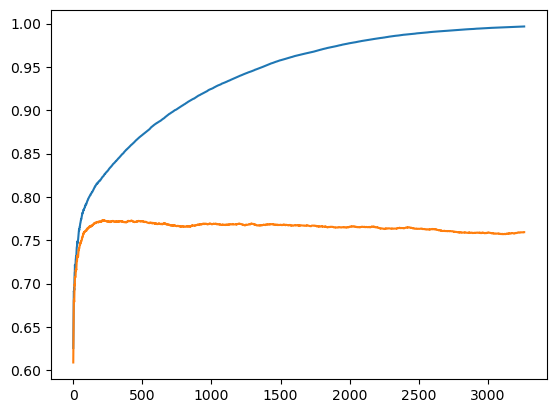

In [298]:
#  regularization = 10
plt.plot(train_acc)
plt.plot(test_acc)

In [303]:
train_acc[np.argmax(test_acc)],max(test_acc),np.argmax(test_acc)

(0.82285053523431, 0.7734110367757965, 211)

In [301]:
max(train_acc),test_acc[np.argmax(train_acc)]

(0.9967120394680573, 0.7594031318695433)

# Higgs

In [13]:
df = pd.read_csv('../data/HIGGS.csv',header=None)
data_X = df.iloc[:,1:].to_numpy()
data_y = df.iloc[:,0].to_numpy().astype('int')

In [14]:
X_train,X_test2,y_train,y_test2 = train_test_split(data_X,data_y,test_size=500000)
Xs,ys = shuffle(X_train,y_train)

In [18]:
i = 1000000
j = 500000

X_train = Xs[:i]
y_train = ys[:i]

X_test = Xs[i:i+j]
y_test = ys[i:i+j]

In [14]:
train_acc = []
test_acc = []

stack = []
learning_rate = 0.5
bins = 10
lam = 10
max_depth = 3

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

In [19]:
train_acc = []
test_acc = []

stack = []
learning_rate = 0.1
bins = 10
lam = 10
max_depth = 3

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

for g in range(20000):
    #regularization

    start = time()
    
    residual = y_train_one_hot - p
    
    eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,log_odds,p,learning_rate,bins)
    for j in range(5):
            eg.evolve(30,30,10,lam,max_depth,0)
        
    fitness,node = eg.best
    val = eg.vals[node.index]
    grads = node.estimator.predict_grad(val)
    
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    
    loss = np.sum(np.power(residual,2))
    
    running_time = time() - start
    if not np.isnan(loss):
        stack.append(node)
        
        # test data prediction

        test_residual = y_test_one_hot - test_p
        test_loss = np.sum(np.power(test_residual,2))

        grads = node.predict_grad(X_test)
        test_log_odds,test_p = update_log_p(grads,test_log_odds,test_p,learning_rate)

        # train_acc.append(loss)
        # test_acc.append(test_loss)

        # pred = np.argmax(p,axis=1)
        # train_acc.append(accuracy_score(y_train,pred))
        # pred = np.argmax(test_p,axis=1)
        # test_acc.append(accuracy_score(y_test,pred))
        
        pred = p[:,1]
        train_acc.append(roc_auc_score(y_train,pred))
        pred = test_p[:,1]
        test_acc.append(roc_auc_score(y_test,pred))
    
        print("Generation:",g,loss,test_loss,train_acc[-1],test_acc[-1],str(round(running_time,3))+'s')
    else:
        break

KeyboardInterrupt: 

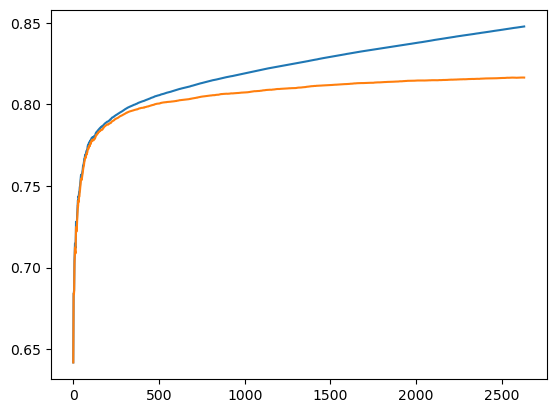

In [306]:
# without regularization
plt.plot(train_acc)
plt.plot(test_acc)

In [316]:
train_acc[np.argmax(test_acc)],max(test_acc),np.argmax(test_acc)

(0.8477279407421849, 0.8164857482543314, 2626)

In [323]:
np.sum([n.numNode for n in stack]),np.average([n.depth for n in stack])

(19477, 2.5343975674648425)

In [329]:
i = 1200
train_acc[i],test_acc[i]

(0.8232995596616015, 0.8094169603706618)

In [330]:
np.sum([n.numNode for n in stack[:i]]),np.average([n.depth for n in stack[:i]])

(8118, 2.3233333333333333)

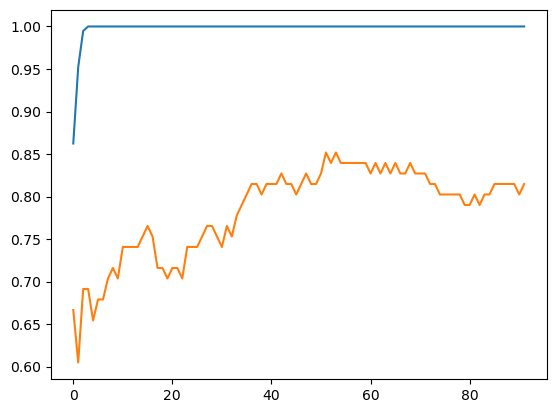

In [ ]:
# without regularization
plt.plot(train_acc)
plt.plot(test_acc)

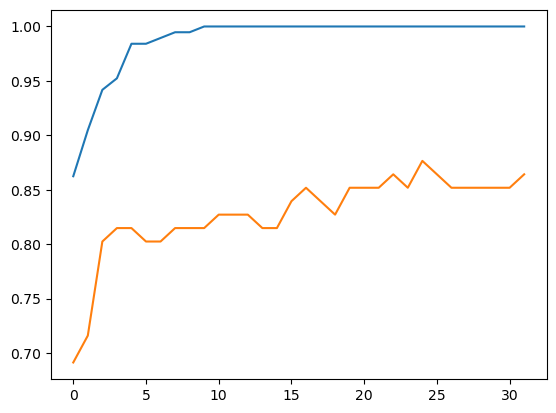

In [ ]:
#with regularization
#lambda = 1
plt.plot(train_acc)
plt.plot(test_acc)

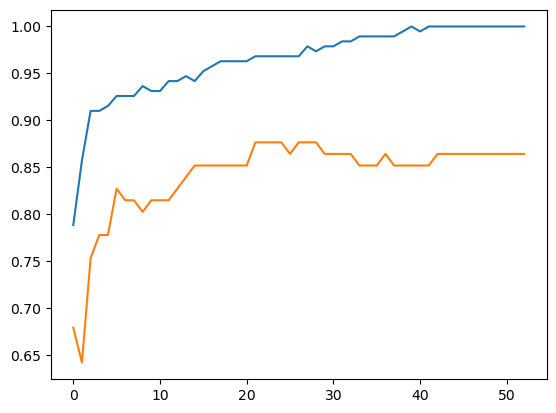

In [ ]:
#with regularization
#lambda = 10
plt.plot(train_acc)
plt.plot(test_acc)

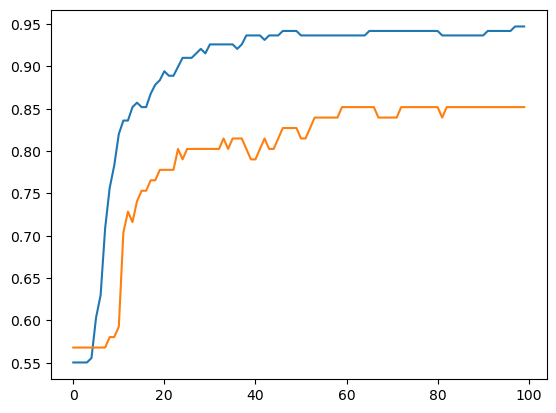

In [ ]:
#with regularization
#lambda = 100
plt.plot(train_acc)
plt.plot(test_acc)

In [331]:
import xgboost

In [377]:
xgb = xgboost.XGBClassifier(n_estimators=100)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [378]:
pred = xgb.predict_proba(X_train)

pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred,digits=3))

pred = xgb.predict_proba(X_train)
pred = pred[:,1]
print(roc_auc_score(y_train,pred))

pred = xgb.predict_proba(X_test)

pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred,digits=3))

pred = xgb.predict_proba(X_test)
pred = pred[:,1]
print(roc_auc_score(y_test,pred))

              precision    recall  f1-score   support

           0      0.789     0.771     0.780     49454
           1      0.800     0.816     0.808     55546

    accuracy                          0.795    105000
   macro avg      0.794     0.794     0.794    105000
weighted avg      0.795     0.795     0.795    105000

0.8783270105723442
              precision    recall  f1-score   support

           0      0.720     0.715     0.717      4997
           1      0.743     0.748     0.745      5503

    accuracy                          0.732     10500
   macro avg      0.731     0.731     0.731     10500
weighted avg      0.732     0.732     0.732     10500

0.8098274374401128


In [379]:
import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

(100, 6.0, 10140)

In [309]:
from sklearn.ensemble import GradientBoostingClassifier

In [371]:
clf = GradientBoostingClassifier(n_estimators=1000).fit(X_train, y_train)

In [372]:
pred = clf.predict_proba(X_train)
pred = pred[:,1]
print(roc_auc_score(y_train,pred))

0.83893373915581


In [373]:
pred = clf.predict_proba(X_test)
pred = pred[:,1]
print(roc_auc_score(y_test,pred))

0.8090403215216428


In [374]:
sum([x[0].tree_.node_count for x in clf.estimators_])

14810

# Covertype

In [13]:
df = pd.read_csv("../data/covtype.data",delimiter=',')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")
y = y - 1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify=y)

In [14]:
feature_space = X_train.shape[1]
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)


learning_rate = 0.3
lam = 10
max_depth = 4
bins = 10

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

stack = []
losses = []

for i in range(feature_space):
    val = X_train[:,i]
    est = Estimator_DC(max_depth,lam)
    est.fit(val,y_train)
    loss = est.get_loss()

    node = Node(terminal=True,index=i,fit=loss,estimator=est)
    stack.append(node)
    losses.append(loss)
index = np.argsort(losses)
losses = [losses[i] for i in index]
stack = [stack[i] for i in index]

In [18]:

tolerance = min([losses[i] - losses[i-1] for i in range(1,len(losses))]) * 5
i = 0

while len(stack) < 12000:
        eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,log_odds,p,learning_rate,bins)
        for j in range(20):
                eg.evolve(10,10,3,lam,max_depth,0)
        # s.extend([eg.best[1]])
        newcomers = eg.nodes[-60:]
        stack,losses = adding_unique_node(stack,losses,newcomers)

        print(i,len(stack))
        i += 1

0 8348
1 8360
2 8383
3 8410
4 8431
5 8440
6 8457
7 8473
8 8488
9 8507
10 8520
11 8535
12 8552
13 8563
14 8578
15 8597
16 8617
17 8635
18 8643
19 8660
20 8671
21 8686
22 8698
23 8716
24 8727
25 8733
26 8755
27 8771
28 8784
29 8802
30 8822
31 8843
32 8859
33 8880
34 8895
35 8911
36 8921
37 8935
38 8949
39 8969
40 8978
41 8994
42 9009
43 9018
44 9029
45 9042
46 9055
47 9070
48 9085
49 9104
50 9123
51 9138
52 9156
53 9171
54 9185
55 9195
56 9213
57 9226
58 9243
59 9265
60 9279
61 9298
62 9316
63 9339
64 9361
65 9368
66 9383
67 9396
68 9412
69 9422
70 9437
71 9453
72 9465
73 9473
74 9489
75 9505
76 9514
77 9537
78 9549
79 9558
80 9580
81 9598
82 9611
83 9627
84 9639
85 9656
86 9672
87 9689
88 9702
89 9721
90 9730
91 9743
92 9755
93 9773
94 9781
95 9797
96 9809
97 9825
98 9836
99 9845
100 9856
101 9865
102 9881
103 9891
104 9911
105 9925
106 9942
107 9963
108 9979
109 9997
110 10018
111 10026
112 10031
113 10044
114 10061
115 10070
116 10082
117 10096
118 10114
119 10132
120 10152
121 10161


In [19]:
fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

# fits = [i.estimator.loss for i in stack]
# unique_nodes = [stack[i] for i in np.unique(fits, return_index=True)[1]]
# unique_fits = [i.estimator.loss for i in unique_nodes]
# a = [unique_nodes[i] for i in np.argsort(unique_fits)]

lam = 12
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

train_acc = []
test_acc = []


train_sse = []
test_sse = []

counts = []


for i,node in enumerate(a):
    node.estimator.lam = lam
    grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

    test_grads = node.predict_grad(X_test)
    test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


    train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
    test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))
    print(train_sse[-1],test_sse[-1],i+1,len(a))


    pred = np.argmax(p,axis=1)
    train_acc.append(accuracy_score(pred,y_train))
    test_pred = np.argmax(test_p,axis=1)
    test_acc.append(accuracy_score(test_pred,y_test))
    print('\t',train_acc[-1],test_acc[-1],i+1,len(a))
    

330338.7428812993 330241.03673942975 1 12012
	 0.674170840433039 0.6746228993549187 1 12012
233821.97186446917 233650.406451532 2 12012
	 0.6771105488717922 0.6778207679015236 2 12012
184560.22912985904 184336.33801102283 3 12012
	 0.6771105488717922 0.6778207679015236 3 12012
158712.75187063342 158447.0240301141 4 12012
	 0.677007280425466 0.6776107894501319 4 12012
144990.44782126637 144696.6193831979 5 12012
	 0.677007280425466 0.6776107894501319 5 12012
137633.8321907296 137317.26848991195 6 12012
	 0.677007280425466 0.6776107894501319 6 12012
133674.25550817128 133341.529018596 7 12012
	 0.6769108965422281 0.6775453863259279 7 12012
131539.13630428095 131194.61185311334 8 12012
	 0.6769108965422281 0.6775453863259279 8 12012
130385.45976337735 130032.37681003493 9 12012
	 0.6769108965422281 0.6775453863259279 9 12012
129760.77532559478 129401.57622505607 10 12012
	 0.6769108965422281 0.6775453863259279 10 12012
129421.88314663353 129058.38186847804 11 12012
	 0.6768971274160513 0.

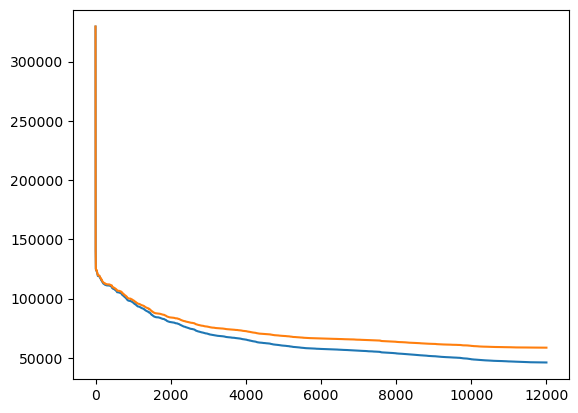

In [57]:
plt.plot(train_sse)
plt.plot(test_sse)

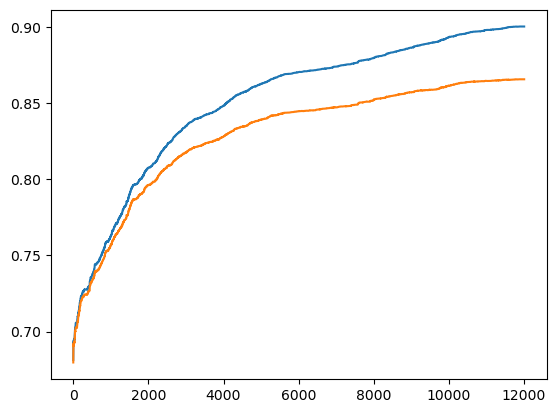

In [58]:
plt.plot(train_acc)
plt.plot(test_acc)

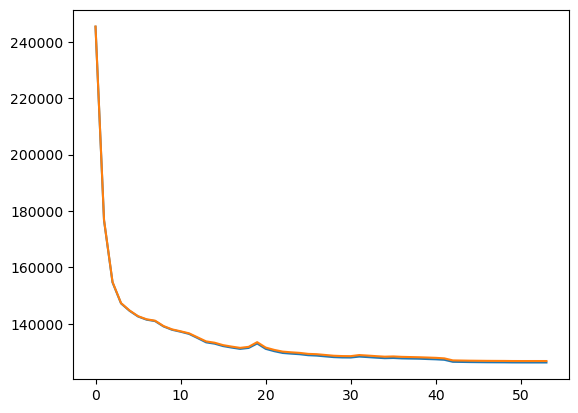

In [39]:
plt.plot(train_sse)
plt.plot(test_sse)

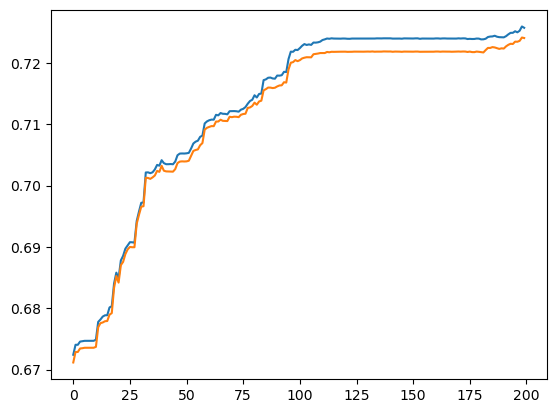

In [40]:
plt.plot(train_acc)
plt.plot(test_acc)

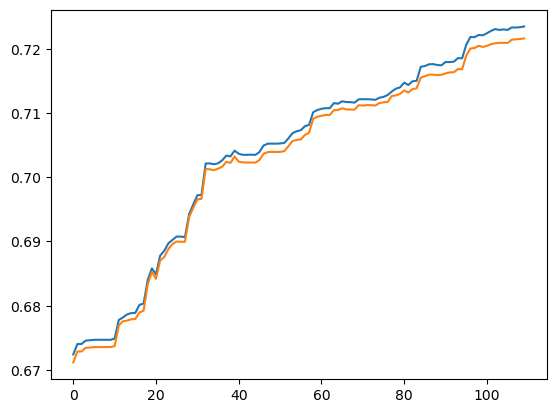

In [38]:
plt.plot(train_acc)
plt.plot(test_acc)

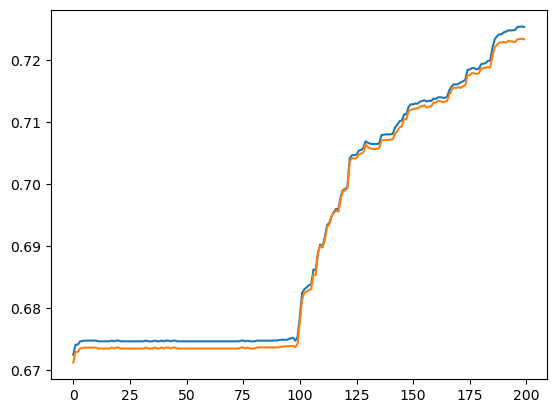

In [35]:
plt.plot(train_acc)
plt.plot(test_acc)

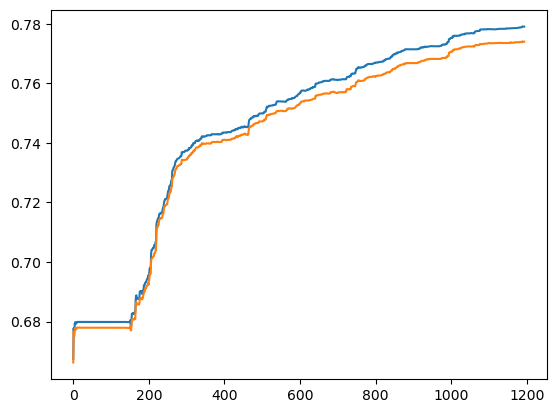

In [500]:
plt.plot(train_acc)
plt.plot(test_acc)

In [59]:
import xgboost

xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)

pred = xgb.predict_proba(X_train)

pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred,digits=3))

# pred = xgb.predict_proba(X_train)
# pred = pred[:,1]
# print(roc_auc_score(y_train,pred))

pred = xgb.predict_proba(X_test)

pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred,digits=3))

# pred = xgb.predict_proba(X_test)
# pred = pred[:,1]
# print(roc_auc_score(y_test,pred))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0      0.872     0.850     0.861    105920
           1      0.877     0.905     0.891    141650
           2      0.933     0.937     0.935     17877
           3      0.978     0.980     0.979      1374
           4      0.921     0.633     0.750      4746
           5      0.891     0.877     0.884      8683
           6      0.965     0.939     0.952     10255

    accuracy                          0.883    290505
   macro avg      0.920     0.874     0.893    290505
weighted avg      0.883     0.883     0.883    290505

              precision    recall  f1-score   support

           0      0.859     0.839     0.849    105920
           1      0.865     0.894     0.879    141651
           2      0.895     0.904     0.900     17877
           3      0.877     0.859     0.868      1373
           4      0.874     0.571     0.691      4746
           5      0.837     0.806     0.821      8684
           6      0.949 

(700, 6.0, 51356)

# Connect-4

In [19]:
df = pd.read_csv("../data/connect-4.tsv",delimiter='\t')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify=y)

In [21]:
feature_space = X_train.shape[1]
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)


learning_rate = 0.3
lam = 10
max_depth = 4
bins = 10

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

stack = []
losses = []

for i in range(feature_space):
    val = X_train[:,i]
    est = Estimator_DC(max_depth,lam)
    est.fit(val,y_train)
    loss = est.get_loss()

    node = Node(terminal=True,index=i,fit=loss,estimator=est)
    stack.append(node)
    losses.append(loss)
index = np.argsort(losses)
losses = [losses[i] for i in index]
stack = [stack[i] for i in index]